# Finetuning BERT with Keras and tf.Module

In this experiment we convert a pre-trained BERT model checkpoint into a trainable Keras layer, which we use to solve a sentence pair classification task.

We achieve this using a tf.Module, which is a neat abstraction designed to handle pre-trained Tensorflow models.
Exported modules can be easily integrated into other models, which facilitates experiments with powerful NN architectures.

The plan for this experiment is:

1.   getting a pre-trained BERT model checkpoint
2.   defining the specification of the tf.Module
3.   exporting the module
4.   building the text preprocessing pipeline
5.   implementing a custom Keras layer
6.   training a Keras model to solve a sentence-pair classification task


# What is in this guide?
This guide is about integrating pre-trained Tensorflow models into Keras pipelines. It contains implementations of two things: a BERT tf.Module and a Keras layer built on top of it.
# What does it take?
For a reader familiar with TensorFlow it should take around 30 minutes to finish this guide.



In [1]:
# !git clone https://github.com/google-research/bert bert_repo

import re
import os
import sys
import json

import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
# from google.colab import auth, drive

if not 'bert_repo' in sys.path:
    sys.path.insert(0, 'bert_repo')

from modeling import BertModel, BertConfig
from tokenization import FullTokenizer, convert_to_unicode
from extract_features import InputExample, convert_examples_to_features


# get TF logger 
log = logging.getLogger('tensorflow')
log.handlers = []

## Step 1: getting the pre-trained model

In [8]:
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
# !unzip uncased_L-12_H-768_A-12.zip

## Step 2: building a tf.Module

**tf.Modules** are designed to provide a simple way to manipulate reusable parts of pre-trained machine learning models in Tensorflow. Google maintains a curated library of such modules at tf.Hub. In this guide however, we will build one by ourselves.

To that end, we will need to implement a ***module_fn*** which will contain the full specification of the module inner workings. 
We begin by defining input placeholders. Then the BERT graph is created from a configuration file passed through ***config_path***. Then we model outputs are defined: the final encoder layer to seq_output and pooled *'**CLS**'* token representation to pool_output.

Additionally, extra assets may be bundled with the module. In this example, we add a ***vocab_file*** containing the WordPiece vocabulary to the module assets. As a result, the vocabulary file will be exported with the module, which will make it self-contained.

In [2]:
def build_module_fn(config_path, vocab_path, do_lower_case=True):

    def bert_module_fn(is_training):
        """Spec function for a token embedding module."""

        input_ids = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_ids")
        input_mask = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_mask")
        token_type = tf.placeholder(shape=[None, None], dtype=tf.int32, name="segment_ids")

        config = BertConfig.from_json_file(config_path)
        model = BertModel(config=config, is_training=is_training,
                          input_ids=input_ids, input_mask=input_mask, token_type_ids=token_type)
          
        seq_output = model.all_encoder_layers[-1]
        pool_output = model.get_pooled_output()

        config_file = tf.constant(value=config_path, dtype=tf.string, name="config_file")
        vocab_file = tf.constant(value=vocab_path, dtype=tf.string, name="vocab_file")
        lower_case = tf.constant(do_lower_case)

        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, config_file)
        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, vocab_file)
        
        input_map = {"input_ids": input_ids,
                     "input_mask": input_mask,
                     "segment_ids": token_type}
        
        output_map = {"pooled_output": pool_output,
                      "sequence_output": seq_output}

        output_info_map = {"vocab_file": vocab_file,
                           "do_lower_case": lower_case}
                
        hub.add_signature(name="tokens", inputs=input_map, outputs=output_map)
        hub.add_signature(name="tokenization_info", inputs={}, outputs=output_info_map)

    return bert_module_fn

Finally, we define signatures, which are particular transformations of inputs to outputs exposed to module consumers. One could think of it as a module interface with the outside world.

Here we add two signatures to the module: one that takes raw text features as input and returns computed text representations as output. The other takes no inputs and returns the path to vocabulary file and lowercase flag.

## Step 3: exporting the module

Now that the module_fn is defined, we can use it to build and export the module. Passing the tags_and_args argument to create_module_spec will result in two graph variants being added to the module: for training with tags ***{"train"}*** and for inference with an empty set of tags. This allows to control dropout, which is disabled at inference time, and enabled during training.

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
MODEL_DIR = "uncased_L-12_H-768_A-12" #@param {type:"string"} ['uncased_L-12_H-768_A-12']

config_path = "./{}/bert_config.json".format(MODEL_DIR)
vocab_path = "./{}/vocab.txt".format(MODEL_DIR)

tags_and_args = []
for is_training in (True, False):
  tags = set()
  if is_training:
    tags.add("train")
  tags_and_args.append((tags, dict(is_training=is_training)))

module_fn = build_module_fn(config_path, vocab_path)
spec = hub.create_module_spec(module_fn, tags_and_args=tags_and_args)
spec.export("bert-module", 
            checkpoint_path="./{}/bert_model.ckpt".format(MODEL_DIR), )

W0427 18:13:05.699476 157700 deprecation_wrapper.py:119] From bert_repo\modeling.py:171: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0427 18:13:05.702468 157700 deprecation_wrapper.py:119] From bert_repo\modeling.py:409: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0427 18:13:05.744387 157700 deprecation_wrapper.py:119] From bert_repo\modeling.py:490: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.

W0427 18:13:07.877779 157700 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0427 18:13:07.895733 157700 deprecation.py:5

In [7]:
# !ls ./uncased_L-12_H-768_A-12

bert_config.json		     bert_model.ckpt.index  vocab.txt
bert_model.ckpt.data-00000-of-00001  bert_model.ckpt.meta


## Step 4: building the text preprocessing pipeline

The BERT model requires that text is represented as 3 matrices containing ***input_ids***, ***input_mask***, and ***segment_ids***. In this step we build a pipeline which takes a list of strings, and outputs these three matrices, as simple as that.

First of all, raw input text is converted into ***InputExamples***. If the input text is a sentence pair, separated by a special '|||' sequence, the sentences are split.

In [3]:
def read_examples(str_list):
    """Read a list of `InputExample`s from a list of strings."""
    unique_id = 0
    for s in str_list:
        line = convert_to_unicode(s)
        if not line:
            continue
        line = line.strip()
        text_a = None
        text_b = None
        m = re.match(r"^(.*) \|\|\| (.*)$", line)
        if m is None:
            text_a = line
        else:
            text_a = m.group(1)
            text_b = m.group(2)
        yield InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b)
        unique_id += 1

***InputExamples*** are then tokenized and converted to ***InputFeatures*** using the ***convert_examples_to_features*** function from the original repository. However, we will require these features to be converted to np.arrays to use with Keras.

In [4]:
def features_to_arrays(features):

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.input_type_ids)

    return (np.array(all_input_ids, dtype='int32'), 
            np.array(all_input_mask, dtype='int32'), 
            np.array(all_segment_ids, dtype='int32'))

Finally, let us put it all together in a single pipeline.

In [5]:
def build_preprocessor(voc_path, seq_len, lower=True):
  tokenizer = FullTokenizer(vocab_file=voc_path, do_lower_case=lower)
  
  def strings_to_arrays(sents):
  
      sents = np.atleast_1d(sents).reshape((-1,))

      examples = []
      for example in read_examples(sents):
          examples.append(example)

      features = convert_examples_to_features(examples, seq_len, tokenizer)
      arrays = features_to_arrays(features)
      return arrays
  
  return strings_to_arrays

All done!

## Step 5: implementing a BERT Keras layer

In [6]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_path, seq_len=64, n_tune_layers=3, 
                 pooling="cls", do_preprocessing=True, verbose=False,
                 tune_embeddings=False, trainable=True, **kwargs):

        self.trainable = trainable
        self.n_tune_layers = n_tune_layers
        self.tune_embeddings = tune_embeddings
        self.do_preprocessing = do_preprocessing

        self.verbose = verbose
        self.seq_len = seq_len
        self.pooling = pooling
        self.bert_path = bert_path

        self.var_per_encoder = 16
        if self.pooling not in ["cls", "mean", None]:
            raise NameError(
                f"Undefined pooling type (must be either 'cls', 'mean', or None, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.bert = hub.Module(self.build_abspath(self.bert_path), 
                               trainable=self.trainable, name=f"{self.name}_module")

        trainable_layers = []
        if self.tune_embeddings:
            trainable_layers.append("embeddings")

        if self.pooling == "cls":
            trainable_layers.append("pooler")

        if self.n_tune_layers > 0:
            encoder_var_names = [var.name for var in self.bert.variables if 'encoder' in var.name]
            n_encoder_layers = int(len(encoder_var_names) / self.var_per_encoder)
            for i in range(self.n_tune_layers):
                trainable_layers.append(f"encoder/layer_{str(n_encoder_layers - 1 - i)}/")
        
        # Add module variables to layer's trainable weights
        for var in self.bert.variables:
            if any([l in var.name for l in trainable_layers]):
                self._trainable_weights.append(var)
            else:
                self._non_trainable_weights.append(var)

        if self.verbose:
            print("*** TRAINABLE VARS *** ")
            for var in self._trainable_weights:
                print(var)

        self.build_preprocessor()
        self.initialize_module()

        super(BertLayer, self).build(input_shape)

    def build_abspath(self, path):
        if path.startswith("https://") or path.startswith("gs://"):
          return path
        else:
          return os.path.abspath(path)

    def build_preprocessor(self):
        sess = tf.keras.backend.get_session()
        tokenization_info = self.bert(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        self.preprocessor = build_preprocessor(vocab_file, self.seq_len, do_lower_case)

    def initialize_module(self):
        sess = tf.keras.backend.get_session()
        
        vars_initialized = sess.run([tf.is_variable_initialized(var) 
                                     for var in self.bert.variables])

        uninitialized = []
        for var, is_initialized in zip(self.bert.variables, vars_initialized):
            if not is_initialized:
                uninitialized.append(var)

        if len(uninitialized):
            sess.run(tf.variables_initializer(uninitialized))

    def call(self, input):

        if self.do_preprocessing:
          input = tf.numpy_function(self.preprocessor, 
                                    [input], [tf.int32, tf.int32, tf.int32], 
                                    name='preprocessor')
          for feature in input:
            feature.set_shape((None, self.seq_len))
        
        input_ids, input_mask, segment_ids = input
        
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        output = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)
        
        if self.pooling == "cls":
            pooled = output["pooled_output"]
        else:
            result = output["sequence_output"]
            
            input_mask = tf.cast(input_mask, tf.float32)
            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            
            if self.pooling == "mean":
              pooled = masked_reduce_mean(result, input_mask)
            else:
              pooled = mul_mask(result, input_mask)

        return pooled

    def get_config(self):
        config_dict = {
            "bert_path": self.bert_path, 
            "seq_len": self.seq_len,
            "pooling": self.pooling,
            "n_tune_layers": self.n_tune_layers,
            "tune_embeddings": self.tune_embeddings,
            "do_preprocessing": self.do_preprocessing,
            "verbose": self.verbose
        }
        super(BertLayer, self).get_config()
        return config_dict

## Step 6: sentence pair classification

Now let us try the layer on a real-world dataset. For this part we will use the [Quora Question Pairs](https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs) dataset which consists of over 400,000 potential question duplicate pairs labeled for semantic equivalence.

In [17]:
# !wget http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv -O quora_train.tsv

We join the question pairs with the "|||" sequence and split them into train and test.

In [42]:
df = pd.read_csv("../personality_data/data.csv")

texts = df.text
df.drop(['text', 'Unnamed: 0'], axis=1, inplace=True)
labels = df.values

# texts = []
# delimiter = " ||| "
# for q1, q2 in zip(df.question1.tolist(), df.question2.tolist()):
#   texts.append(delimiter.join((str(q1), str(q2))))

texts = np.array(texts)

trX, tsX, trY, tsY = train_test_split(texts, labels, shuffle=True, test_size=0.1)

In [43]:
df.columns

Index(['cAGR', 'cCON', 'cEXT', 'cNEU', 'cOPN'], dtype='object')

In [13]:
texts.shape

(3178,)

Building and training a sentence-pair classification model is straighforward:

In [20]:
inp = tf.keras.Input(shape=(1,), dtype=tf.string)
encoder = BertLayer(bert_path="./bert-module/", seq_len=48, tune_embeddings=False,
                    pooling='cls', n_tune_layers=3, verbose=False)
# encoder.trainable = False

h1 = tf.keras.layers.Dense(128, activation='relu')(encoder(inp))
h2 = tf.keras.layers.Dense(64, activation='relu')(h1)
h3 = tf.keras.layers.Dense(32, activation='relu')(h2)
h4 = tf.keras.layers.Dense(16, activation='relu')(h3)


pred = tf.keras.layers.Dense(5, activation='sigmoid')(h4)

model = tf.keras.models.Model(inputs=[inp], outputs=[pred])

print(encoder.trainable)

W0427 18:13:57.251271 157700 deprecation.py:506] From c:\users\kartheek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


True


In [21]:
model.summary()

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, ),
      loss="binary_crossentropy",
      metrics=['accuracy'])

W0427 18:14:08.401031 157700 deprecation.py:323] From c:\users\kartheek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
bert_layer (BertLayer)       (None, 768)               109482240 
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85    

### Training

In [9]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [13]:
saver = keras.callbacks.ModelCheckpoint("bert_tuned_3.hdf5")

hist = model.fit(trX, trY, validation_data=[tsX, tsY], batch_size=128, epochs=5, callbacks=[saver])

Train on 2860 samples, validate on 318 samples
Epoch 1/5
2860/2860 [==============================] - 66s 23ms/sample - loss: 0.5530 - acc: 0.6697 - val_loss: 0.5733 - val_acc: 0.6516
Epoch 2/5
2860/2860 [==============================] - 71s 25ms/sample - loss: 0.5469 - acc: 0.6766 - val_loss: 0.5728 - val_acc: 0.6541
Epoch 3/5
2860/2860 [==============================] - 69s 24ms/sample - loss: 0.5399 - acc: 0.6850 - val_loss: 0.5740 - val_acc: 0.6503
Epoch 4/5
2860/2860 [==============================] - 73s 25ms/sample - loss: 0.5340 - acc: 0.6940 - val_loss: 0.5737 - val_acc: 0.6535
Epoch 5/5
2860/2860 [==============================] - 72s 25ms/sample - loss: 0.5288 - acc: 0.6972 - val_loss: 0.5724 - val_acc: 0.6591


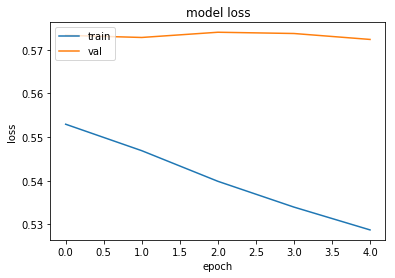

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Step 7: saving and restoring

In [16]:
model.predict(trX[:10])

array([[0.68055534, 0.31686515, 0.5492288 , 0.19271302, 0.94487745],
       [0.38152623, 0.4261461 , 0.43594748, 0.49153474, 0.06401667],
       [0.31303954, 0.34893757, 0.35519063, 0.5158832 , 0.01817501],
       [0.38691646, 0.428504  , 0.4405269 , 0.47391734, 0.06708089],
       [0.37010187, 0.37845913, 0.3868185 , 0.47120234, 0.02930057],
       [0.6074951 , 0.45277885, 0.68986475, 0.44066992, 0.961125  ],
       [0.402719  , 0.39206484, 0.44025055, 0.39353317, 0.04253593],
       [0.56434953, 0.49045318, 0.69330794, 0.6118047 , 0.95182693],
       [0.54166317, 0.4677839 , 0.6129382 , 0.704936  , 0.9308933 ],
       [0.42561972, 0.4053361 , 0.41189033, 0.6060305 , 0.22798362]],
      dtype=float32)

In [17]:
import json
json.dump(model.to_json(), open("model.json", "w"))

In [7]:
model = tf.keras.models.model_from_json(json.load(open("model.json")), 
                                        custom_objects={"BertLayer": BertLayer})

model.load_weights("bert_tuned_3.hdf5")

W0428 18:38:17.867848 185548 deprecation.py:506] From c:\users\kartheek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0428 18:38:17.871848 185548 deprecation.py:506] From c:\users\kartheek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0428 18:38:17.875849 185548 deprecation.py:506] From c:\users\kartheek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_

In [19]:
model.predict(trX[:10])

array([[0.68055534, 0.31686515, 0.5492288 , 0.19271302, 0.94487745],
       [0.38152623, 0.4261461 , 0.43594748, 0.49153474, 0.06401667],
       [0.31303954, 0.34893757, 0.35519063, 0.5158832 , 0.01817501],
       [0.38691646, 0.428504  , 0.4405269 , 0.47391734, 0.06708089],
       [0.37010187, 0.37845913, 0.3868185 , 0.47120234, 0.02930057],
       [0.6074951 , 0.45277885, 0.68986475, 0.44066992, 0.961125  ],
       [0.402719  , 0.39206484, 0.44025055, 0.39353317, 0.04253593],
       [0.56434953, 0.49045318, 0.69330794, 0.6118047 , 0.95182693],
       [0.54166317, 0.4677839 , 0.6129382 , 0.704936  , 0.9308933 ],
       [0.42561972, 0.4053361 , 0.41189033, 0.6060305 , 0.22798362]],
      dtype=float32)

In [15]:
trX

array(["I'm not really sure what exactly I'm supposed to do with this. There is some guy in my room that keeps trying to talk to me and I don't know him. I wonder why he's in here. Theres a really old song playing on the radio. I havent heard it in a while. it reminds me of 6th grade. Every song does that, takes me back to a different place in time. Now this song reminds me of my friends Jason and Doug. I wonder what they're doing right now. I miss my old friends. I'm really excited about this weekend. Miami is going to be a blast. I just hope that everything works out. I really want to suprise John, but if I have to tell him I'm coming I guess I will. I really don't want to. That guy won't shut up. I'm thinking I might just take a cab from the airport to the university. My dad said theres a tropical storm. I sure hope it disentigrates before I get there. I hope everything works out with John, though. I think this weekend is going to be the deciding factor of our relationship. Things a

In some cases (e.g. when serving), one might want to optimize the trained model for maximum inference throughput. In TensorFlow this can be achieved by "freezing" the model. 

During "freezing" the model variables are replaced by constants, and the nodes required for training are pruned from the computational graph. The resulting graph becomes more lightweight, requires less RAM and achieves better performance.

In [0]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference

def freeze_keras_model(model, export_path=None, clear_devices=True):
    """
    Freezes a Keras model into a pruned computation graph.

    @param model The Keras model to be freezed.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    
    sess = tf.keras.backend.get_session()
    graph = sess.graph
    
    with graph.as_default():

        input_tensors = model.inputs
        output_tensors = model.outputs
        dtypes = [t.dtype.as_datatype_enum for t in input_tensors]
        input_ops = [t.name.rsplit(":", maxsplit=1)[0] for t in input_tensors]
        output_ops = [t.name.rsplit(":", maxsplit=1)[0] for t in output_tensors]
        
        tmp_g = graph.as_graph_def()
        if clear_devices:
            for node in tmp_g.node:
                node.device = ""
        
        tmp_g = optimize_for_inference(
            tmp_g, input_ops, output_ops, dtypes, False)
        
        tmp_g = convert_variables_to_constants(sess, tmp_g, output_ops)
        
        if export_path is not None:
            with tf.gfile.GFile(export_path, "wb") as f:
                f.write(tmp_g.SerializeToString())
        
        return tmp_g

We freeze our trained model and write the serialized graph to file.

In [0]:
frozen_graph = freeze_keras_model(model, export_path="frozen_graph.pb")

Now let's restore the frozen graph and do some inference.

In [0]:
!git clone https://github.com/gaphex/bert_experimental/

import tensorflow as tf
import numpy as np
import sys

# sys.path.insert(0, "/content/bert_experimental")

from bert_experimental.finetuning.text_preprocessing import build_preprocessor
from bert_experimental.finetuning.graph_ops import load_graph

In [0]:
restored_graph = load_graph("frozen_graph.pb")

To run inference we need to get the handles for input and output tensors of the graph. This part a little tricky: we retrieve a list of all operations in the restored graph and then manually get the names of relevant ops. The list is sorted, so in this case it is enough to take the first and the last operation.

 To get the Tensor name we append **":0"** to the op name.

In [0]:
graph_ops = restored_graph.get_operations()
input_op, output_op = graph_ops[0].name, graph_ops[-1].name
print(input_op, output_op)

In [0]:
x = restored_graph.get_tensor_by_name(input_op + ':0')
y = restored_graph.get_tensor_by_name(output_op + ':0')

The preprocessing function we injected into the Keras layer is not serializable and was not restored in the new graph. No worries though - we can simply define it again with the same name.

In [0]:
preprocessor = build_preprocessor("./uncased_L-12_H-768_A-12/vocab.txt", 64)
py_func = tf.numpy_function(preprocessor, [x], [tf.int32, tf.int32, tf.int32], name='preprocessor')

In [0]:
py_func = tf.numpy_function(preprocessor, [x], [tf.int32, tf.int32, tf.int32])

Finally, we can get the predictions.

In [0]:
sess = tf.Session(graph=restored_graph)

In [0]:
trX[:10]

In [0]:
y_out = sess.run(y, feed_dict={
        x: trX[:10].reshape((-1,1))
    })

y_out

# Inference

In [46]:
df_new = pd.read_csv('../Actor Quotes.csv')

In [47]:
df_new.head()

,Unnamed: 0,Actor,Quotes
0,0,Aamir Khan,"The journey that I have undertaken, meeting pe..."
1,1,Aasif Mandvi,"If you don't acknowledge differences, it's as ..."
2,2,Abhimanyu Singh,Karthi is such a wonderful human being. He is ...
3,3,Abhishek Bachchan,"You can work really hard on your physicality, ..."
4,4,Aditya Roy Kapur,I am not good with PR or in projecting a certa...


In [48]:
df_new.isna().count()

Unnamed: 0    266
Actor         266
Quotes        266
dtype: int64

In [49]:
text = np.array(text)
text.shape

(266,)

In [50]:
predictions = model.predict(text)

In [51]:
predictions.shape

(266, 5)

In [52]:
predictions = np.where(predictions > 0.5, 1, 0)

In [67]:
traits = pd.DataFrame(columns=['Actor', 'cAGR', 'cCON', 'cEXT', 'cNEU', 'cOPN'])

In [68]:
df_new.columns

Index(['Unnamed: 0', 'Actor', 'Quotes'], dtype='object')

In [69]:
traits.head()

,Actor,cAGR,cCON,cEXT,cNEU,cOPN


In [70]:
for actor, traits_ in zip(df_new['Actor'], predictions):
    _ = pd.DataFrame([[actor] + traits_.tolist()], columns=['Actor', 'cAGR', 'cCON', 'cEXT', 'cNEU', 'cOPN'])
    
    traits = traits.append(_, ignore_index=True)
#     print(actor, traits)
#     break

In [72]:
traits.shape

(266, 6)

In [73]:
traits.to_csv('Actor Traits.csv')